In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3a
commitnumber = 5014a19
conc = 0.0004
dv = 0.01
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 300
vmax = 620
vmin = 540
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

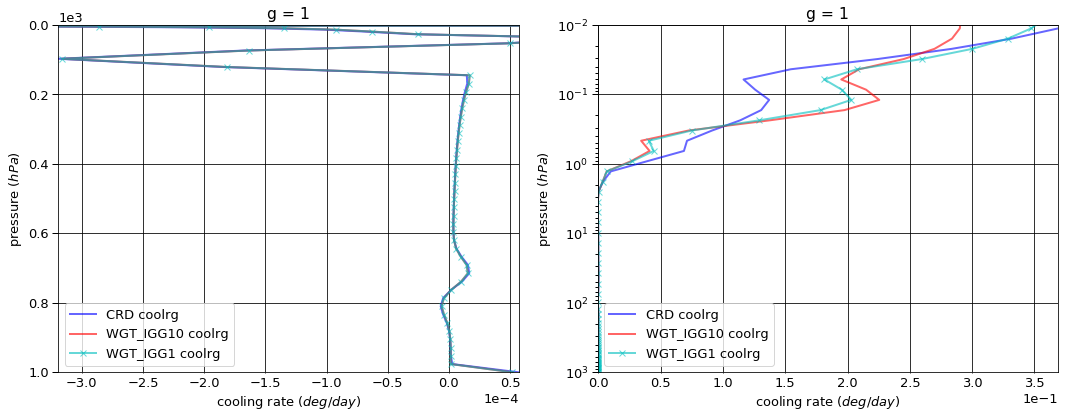

# Figure: cooling rate g-group 2

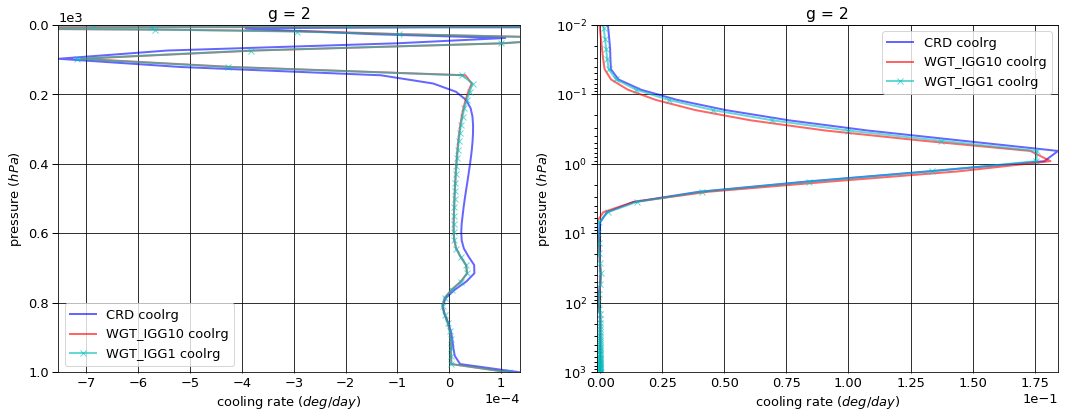

# Figure: cooling rate g-group 3

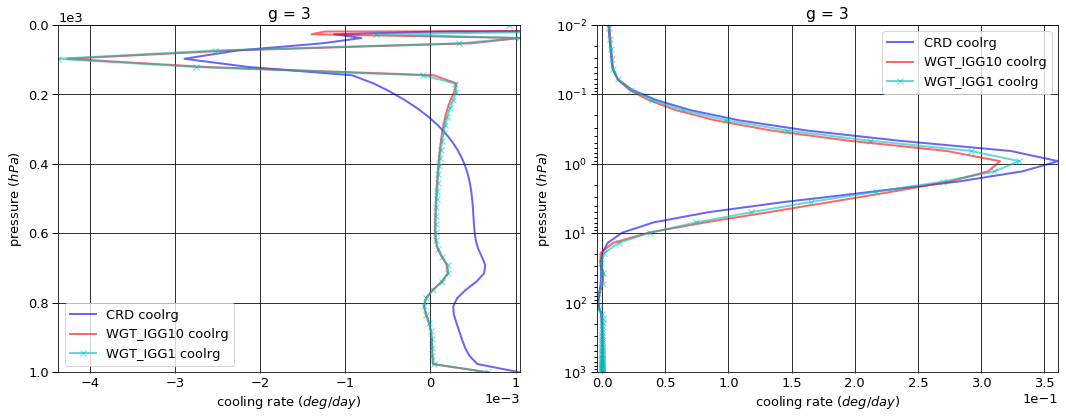

# Figure: cooling rate g-group 4

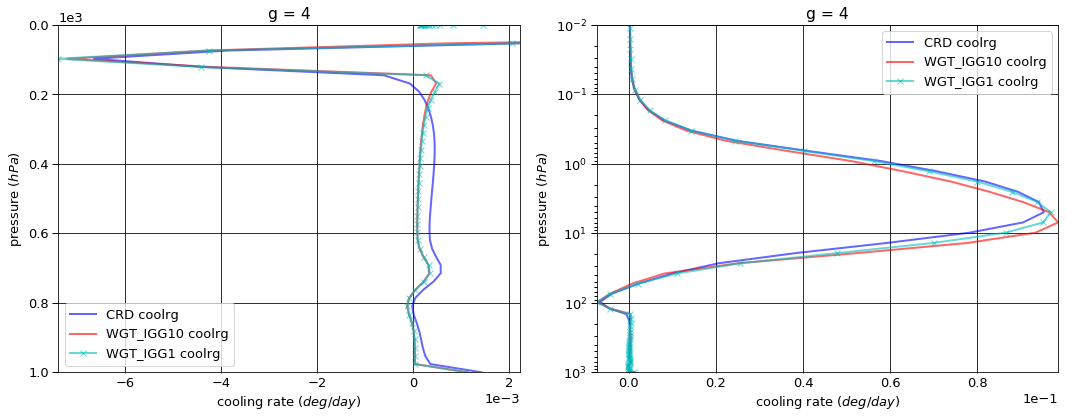

# Figure: cooling rate g-group 5

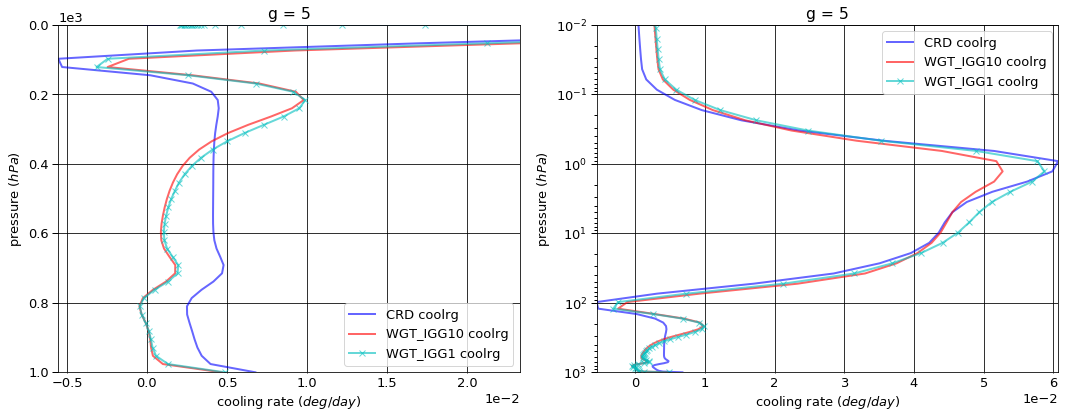

# Figure: cooling rate g-group 6

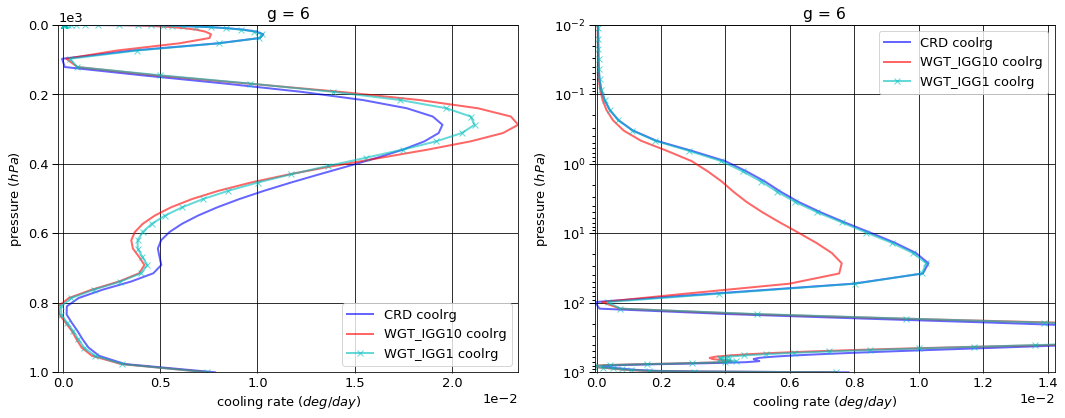

# Figure: cooling rate g-group 7

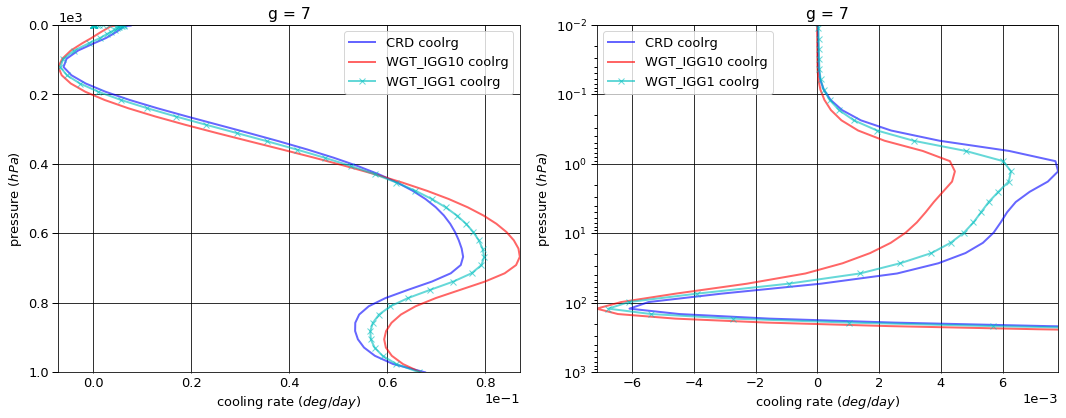

# Figure: cooling rate g-group 8

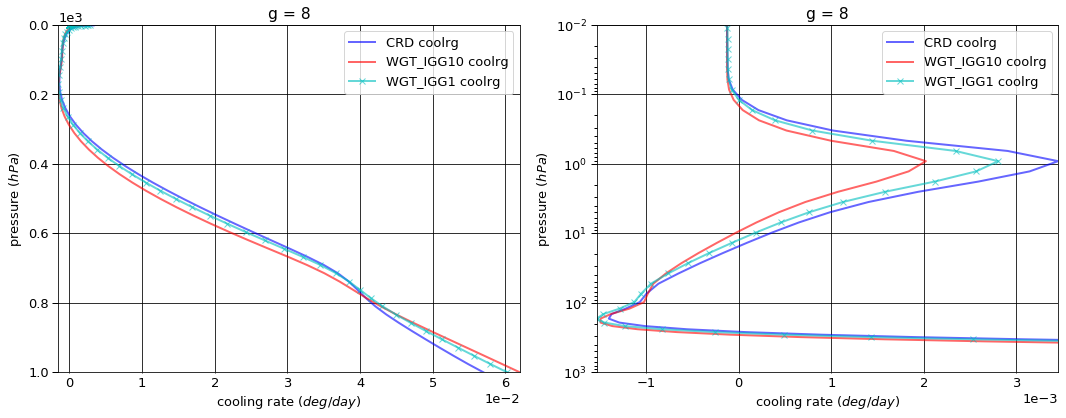

# Figure: cooling rate g-group 9

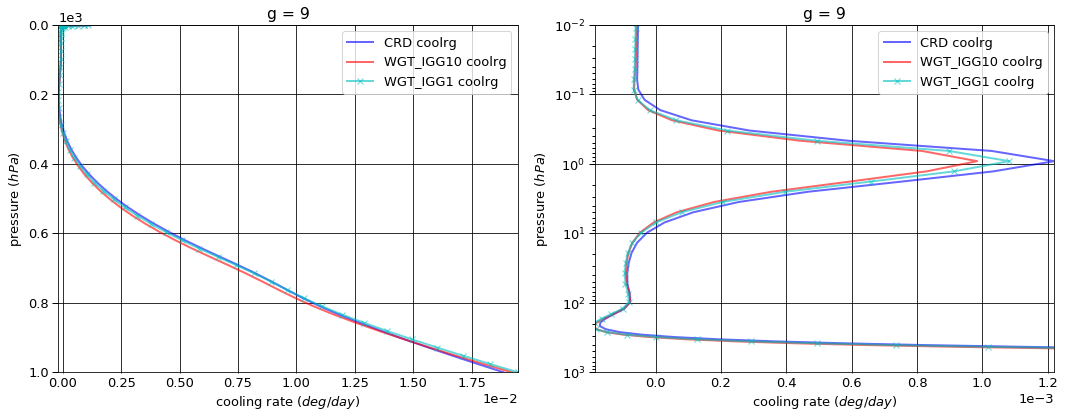

# Figure: cooling rate g-group total

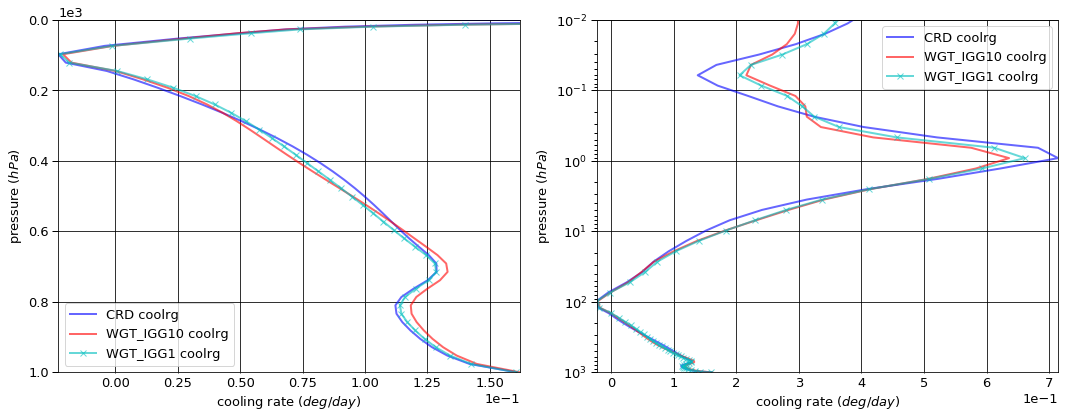

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.010326  0.000000  -0.010326
  1013.0   76     -0.024054  0.023891  -0.000163
2 0.0      1      -0.032693  0.000000  -0.032693
  1013.0   76     -0.052930  0.052490  -0.000441
3 0.0      1      -0.165887  0.000000  -0.165887
  1013.0   76     -0.303262  0.288334  -0.014928
4 0.0      1      -0.210672  0.000000  -0.210672
  1013.0   76     -0.519726  0.512872  -0.006854
5 0.0      1      -0.766520  0.000000  -0.766520
  1013.0   76     -1.805419  1.650228  -0.155191
6 0.0      1      -0.958362  0.000000  -0.958362
  1013.0   76     -2.469947  2.434072  -0.035875
7 0.0      1      -6.721393  0.000000  -6.721393
  1013.0   76    -10.347937  8.953518  -1.394419
8 0.0      1      -7.939938  0.000000  -7.939938
  1013.0   76     -8.760318  3.286362  -5.473956
9 0.0      1     -14.071635  0.000000 -14.071635
  1013.0   76    -14.208141  0.748725 -13.459416


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009579  0.000000  -0.009579
  1013.0   76     -0.023364  0.023219  -0.000144
2 0.0      1      -0.033085  0.000000  -0.033085
  1013.0   76     -0.051529  0.051210  -0.000320
3 0.0      1      -0.163488  0.000000  -0.163488
  1013.0   76     -0.296885  0.295010  -0.001875
4 0.0      1      -0.214817  0.000000  -0.214817
  1013.0   76     -0.506258  0.503128  -0.003130
5 0.0      1      -0.548019  0.000000  -0.548019
  1013.0   76     -1.770520  1.754964  -0.015556
6 0.0      1      -0.930696  0.000000  -0.930696
  1013.0   76     -2.412784  2.381682  -0.031102
7 0.0      1      -6.725536  0.000000  -6.725536
  1013.0   76    -10.160987  9.068676  -1.092310
8 0.0      1      -8.058572  0.000000  -8.058572
  1013.0   76     -8.789338  3.128453  -5.660885
9 0.0      1     -14.347859  0.000000 -14.347859
  1013.0   76    -14.480070  0.726263 -13.753807


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.009627  0.000000  -0.009627
  1013.0   76     -0.023364  0.023219  -0.000144
2 0.0      1      -0.032710  0.000000  -0.032710
  1013.0   76     -0.051529  0.051207  -0.000322
3 0.0      1      -0.162075  0.000000  -0.162075
  1013.0   76     -0.296885  0.294947  -0.001937
4 0.0      1      -0.212892  0.000000  -0.212892
  1013.0   76     -0.506258  0.503118  -0.003140
5 0.0      1      -0.566524  0.000000  -0.566524
  1013.0   76     -1.770520  1.752827  -0.017693
6 0.0      1      -0.930606  0.000000  -0.930606
  1013.0   76     -2.412784  2.380180  -0.032604
7 0.0      1      -6.645169  0.000000  -6.645169
  1013.0   76    -10.160987  8.957636  -1.203350
8 0.0      1      -7.982732  0.000000  -7.982732
  1013.0   76     -8.789338  3.284462  -5.504876
9 0.0      1     -14.340984  0.000000 -14.340984
  1013.0   76    -14.480070  0.753449 -13.726621


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000747  0.000000  0.000747
  1013.0   76     0.000691 -0.000672  0.000019
2 0.0      1     -0.000392  0.000000 -0.000392
  1013.0   76     0.001401 -0.001280  0.000121
3 0.0      1      0.002400  0.000000  0.002400
  1013.0   76     0.006377  0.006676  0.013053
4 0.0      1     -0.004146  0.000000 -0.004146
  1013.0   76     0.013468 -0.009744  0.003724
5 0.0      1      0.218501  0.000000  0.218501
  1013.0   76     0.034899  0.104736  0.139635
6 0.0      1      0.027666  0.000000  0.027666
  1013.0   76     0.057163 -0.052390  0.004773
7 0.0      1     -0.004144  0.000000 -0.004144
  1013.0   76     0.186950  0.115158  0.302108
8 0.0      1     -0.118634  0.000000 -0.118634
  1013.0   76    -0.029020 -0.157908 -0.186929
9 0.0      1     -0.276224  0.000000 -0.276224
  1013.0   76    -0.271929 -0.022462 -0.294391


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000700  0.000000  0.000700
  1013.0   76     0.000691 -0.000672  0.000019
2 0.0      1     -0.000017  0.000000 -0.000017
  1013.0   76     0.001401 -0.001282  0.000119
3 0.0      1      0.003812  0.000000  0.003812
  1013.0   76     0.006377  0.006614  0.012991
4 0.0      1     -0.002221  0.000000 -0.002221
  1013.0   76     0.013468 -0.009754  0.003714
5 0.0      1      0.199996  0.000000  0.199996
  1013.0   76     0.034899  0.102599  0.137498
6 0.0      1      0.027756  0.000000  0.027756
  1013.0   76     0.057163 -0.053891  0.003271
7 0.0      1      0.076224  0.000000  0.076224
  1013.0   76     0.186950  0.004118  0.191068
8 0.0      1     -0.042794  0.000000 -0.042794
  1013.0   76    -0.029020 -0.001900 -0.030920
9 0.0      1     -0.269349  0.000000 -0.269349
  1013.0   76    -0.271929  0.004724 -0.267205

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1      0.413546
  1001.112500 75     0.000057
2 0.000312    1     -0.001709
  1001.112500 75     0.000136
3 0.000312    1      0.000205
  1001.112500 75     0.001050
4 0.000312    1      0.000099
  1001.112500 75     0.001421
5 0.000312    1     -0.000171
  1001.112500 75     0.006776
6 0.000312    1      0.000027
  1001.112500 75     0.007824
7 0.000312    1     -0.000024
  1001.112500 75     0.067693
8 0.000312    1     -0.000131
  1001.112500 75     0.056978
9 0.000312    1     -0.000048
  1001.112500 75     0.018871


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.231927
  1001.112500 75     0.000052
2 0.000312    1     -0.003290
  1001.112500 75     0.000115
3 0.000312    1      0.001820
  1001.112500 75     0.000667
4 0.000312    1      0.000146
  1001.112500 75     0.001125
5 0.000312    1      0.002000
  1001.112500 75     0.004664
6 0.000312    1      0.000020
  1001.112500 75     0.007448
7 0.000312    1     -0.000034
  1001.112500 75     0.066775
8 0.000312    1     -0.000122
  1001.112500 75     0.061990
9 0.000312    1     -0.000051
  1001.112500 75     0.019224


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.323588
  1001.112500 75     0.000052
2 0.000312    1     -0.002713
  1001.112500 75     0.000115
3 0.000312    1      0.000918
  1001.112500 75     0.000678
4 0.000312    1      0.000138
  1001.112500 75     0.001127
5 0.000312    1      0.002081
  1001.112500 75     0.004861
6 0.000312    1      0.000030
  1001.112500 75     0.007424
7 0.000312    1     -0.000004
  1001.112500 75     0.066500
8 0.000312    1     -0.000124
  1001.112500 75     0.060249
9 0.000312    1     -0.000053
  1001.112500 75     0.019482


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.181619
  1001.112500 75    -0.000005
2 0.000312    1     -0.001581
  1001.112500 75    -0.000021
3 0.000312    1      0.001615
  1001.112500 75    -0.000383
4 0.000312    1      0.000047
  1001.112500 75    -0.000296
5 0.000312    1      0.002170
  1001.112500 75    -0.002112
6 0.000312    1     -0.000006
  1001.112500 75    -0.000376
7 0.000312    1     -0.000010
  1001.112500 75    -0.000917
8 0.000312    1      0.000009
  1001.112500 75     0.005012
9 0.000312    1     -0.000002
  1001.112500 75     0.000353


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.089959
  1001.112500 75    -0.000005
2 0.000312    1     -0.001004
  1001.112500 75    -0.000021
3 0.000312    1      0.000713
  1001.112500 75    -0.000372
4 0.000312    1      0.000039
  1001.112500 75    -0.000294
5 0.000312    1      0.002251
  1001.112500 75    -0.001914
6 0.000312    1      0.000003
  1001.112500 75    -0.000399
7 0.000312    1      0.000021
  1001.112500 75    -0.001192
8 0.000312    1      0.000007
  1001.112500 75     0.003271
9 0.000312    1     -0.000005
  1001.112500 75     0.000611

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.877425,0.000000,-30.877425
1013.0,76,-38.491734,17.950491,-20.541243



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-31.031651,0.000000,-31.031651
1013.0,76,-38.491735,17.932606,-20.559129



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.883318,0.000000,-30.883318
1013.0,76,-38.491735,18.001046,-20.490688



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.542259e-01,0.000000,-0.154226
1013.0,76,-9.380000e-07,-0.017885,-0.017886



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-5.893079e-03,0.000000,-0.005893
1013.0,76,-9.380000e-07,0.050555,0.050555


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.411794
1001.112500,75,0.160805



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.232416
1001.112500,75,0.162060



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.323861
1001.112500,75,0.160490



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.179378
1001.112500,75,0.001255



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.087934
1001.112500,75,-0.000316


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000625,0.000607
2,0.001375,0.001339
3,0.007875,0.007713
4,0.013500,0.013152
5,0.046875,0.045997
6,0.064125,0.062683
7,0.268500,0.263978
8,0.227375,0.228344
9,0.369750,0.376186


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.333865e-19
2,2.151599e-20
3,1.983568e-21
4,1.777292e-21
5,1.650053e-22
6,7.272858e-22
7,6.811052e-23
8,6.378569e-24
9,1.012133e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.333865e-19,NaN,0.000625,0.000607,0.000625,0.000607,1.0
2,2.151599e-20,0.092190,0.001375,0.001339,0.002000,0.001946,1.0
3,1.983568e-21,0.092190,0.007875,0.007713,0.009875,0.009659,1.0
4,1.777292e-21,0.896007,0.013500,0.013152,0.023375,0.022811,10.0
5,1.650053e-22,0.092841,0.046875,0.045997,0.070250,0.068808,10.0
6,7.272858e-22,4.407650,0.064125,0.062683,0.134375,0.131492,500.0
7,6.811052e-23,0.093650,0.268500,0.263978,0.402875,0.395470,500.0
8,6.378569e-24,0.093650,0.227375,0.228344,0.630250,0.623814,500.0
9,1.012133e-25,0.015868,0.369750,0.376186,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
